# Compare models trained on mixed class data

This compares several different models trained on **mixed** *longliner*,
*trawler* and *purse seiner* data.

**NOTE: this was somewhat unstable. Running multiple times yielded significantly different results, 
  depending the data split.  I set seeds everywhere and now the output is stable. However, this tells 
  me that we want more data!**

In [1]:
%matplotlib inline
import numpy as np
import data
from evaluate_model import evaluate_model, train_model, compare_auc
from IPython.core.display import display, HTML

In [2]:
# manually add scores to transit data
# xtransits = np.load('datasets/slow-transits.measures.npz')['x']
# xtransits['classification'] = 0 # All nonfishing
# xtransits['mmsi'] = np.floor(xtransits['mmsi']).astype(int) # MMSI have extraneous extra float portion
# np.savez('datasets/slow-transits_scored.measures.npz', x=xtransits) 

from utils import is_fishy
xtransits = np.load('datasets/slow-transits_scored.measures.npz')['x']

_, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits_scored.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [3]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [4]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_trawl.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_trawl.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_trawl.dtype)

In [5]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_trawl, xtrain_lline, xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_trawl, xcross_lline, xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([xtrain, xcross])

xtest = np.concatenate([xtest_trawl, xtest_lline, xtest_pseine, xtest_tran])

In [6]:
from legacy_heuristic_model import LegacyHeuristicModel
from random_forest_model import RandomForestModel
from logistic_model import LogisticModel

untrained_models = [
    ('Logistic', LogisticModel(windows=[43200], order=6)),
    ('Logistic opt MSE', LogisticModel(windows=[43200], order=4, cross=3)),
#     ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6)),
#     ('Logistic (MW/cross3)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6, cross=2)),
    ('Random Forest', RandomForestModel(windows=[43200])),
#     ('Random Forest (MW)', RandomForestModel(windows=[1800, 3600, 10800, 21600, 43200, 86400])),
    ('Legacy', LegacyHeuristicModel(window=3600)),
#     ("Legacy (3 Hour)", LegacyHeuristicModel(window=10800)),
    ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200)),
#     ("Legacy (24 Hour)", LegacyHeuristicModel(window=86400)),  
]

trained_models = [(name, train_model(mdl, train)) for (name, mdl) in untrained_models]

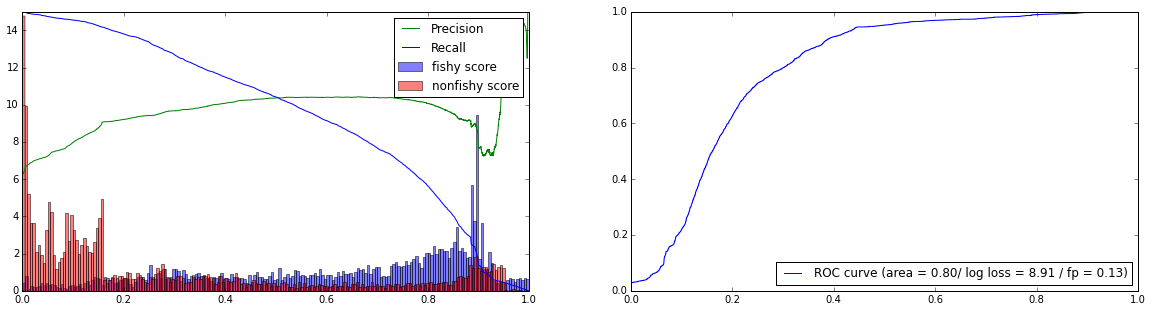

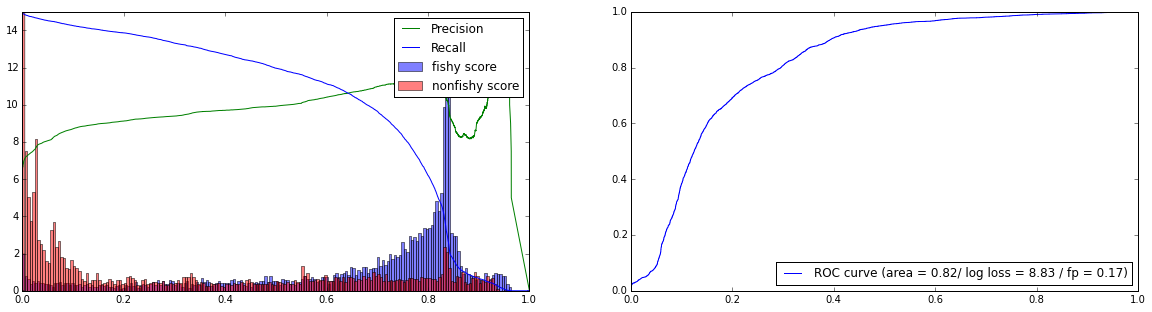

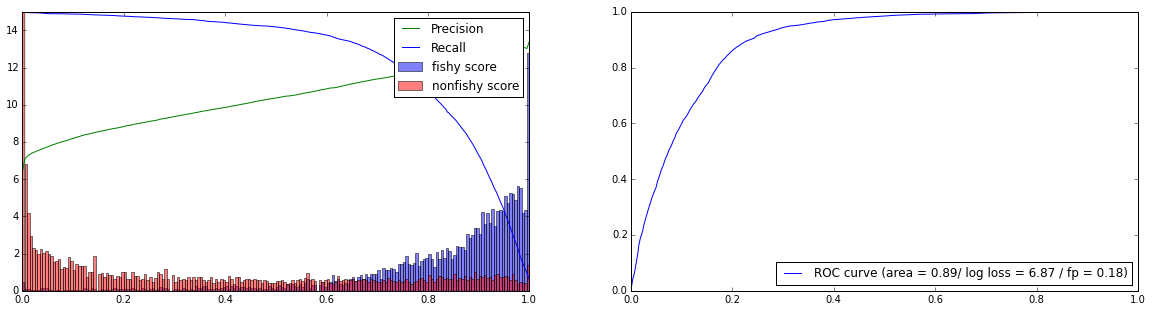

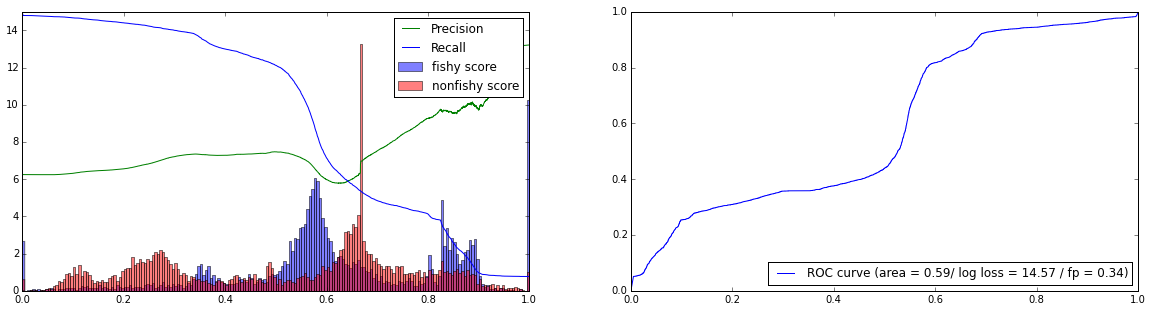

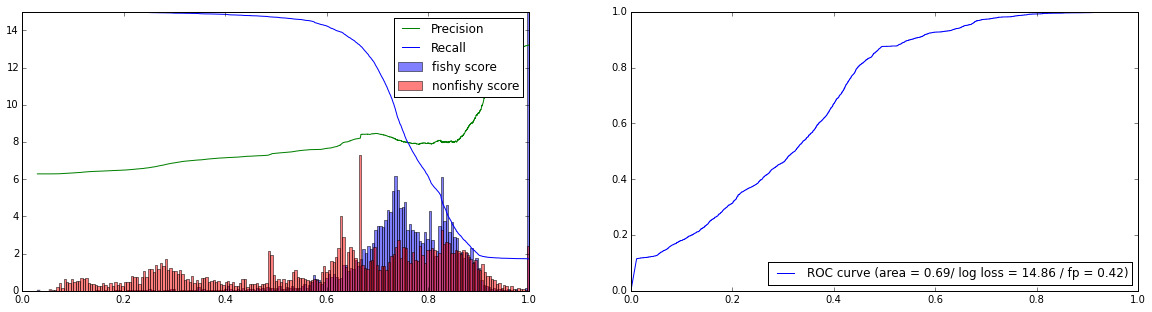

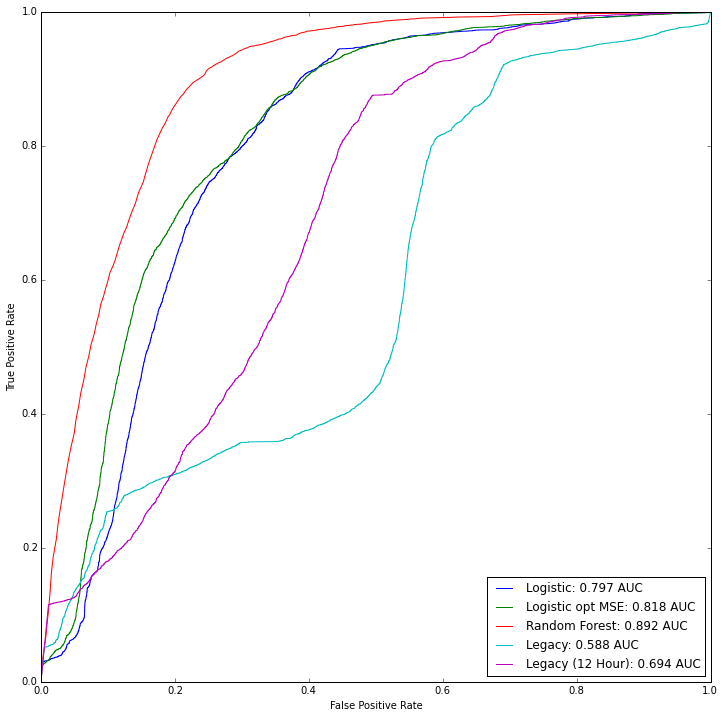

In [7]:
display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in trained_models:
    evaluate_model(mdl, xtest, name=name)

display(HTML("<h1>Overall AUC comparison</h1>"))
compare_auc(trained_models, xtest)

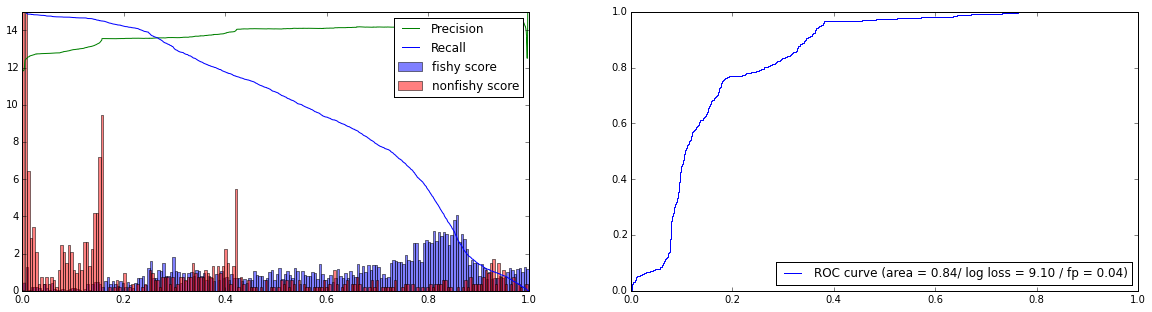

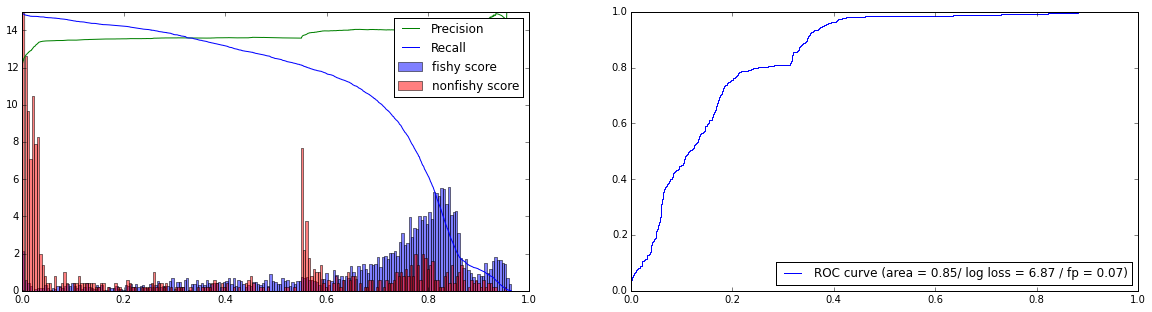

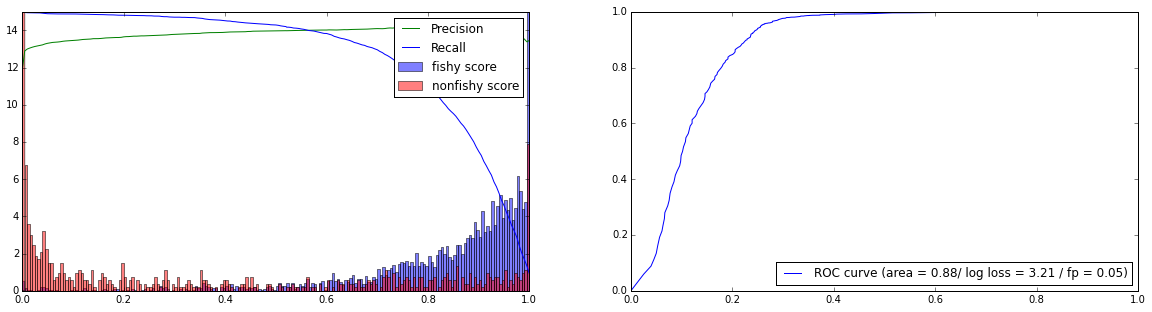

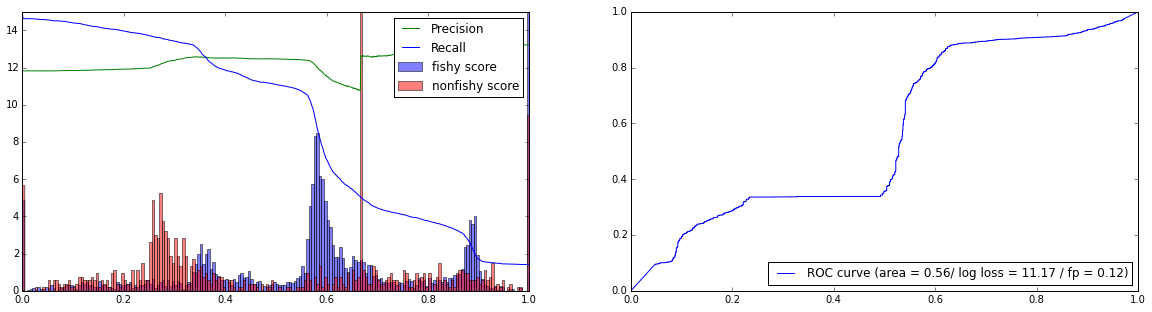

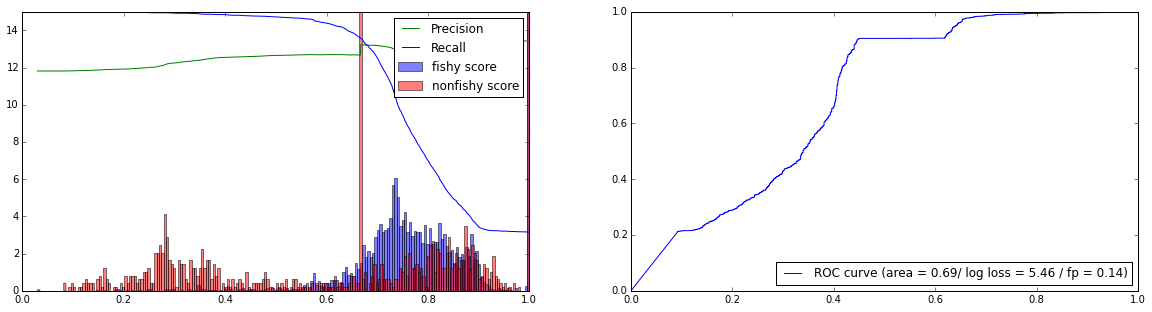

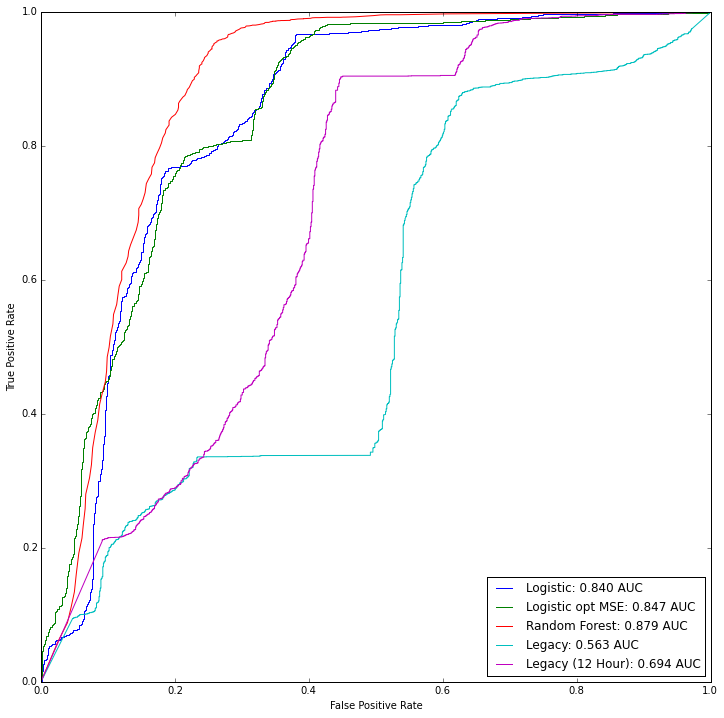

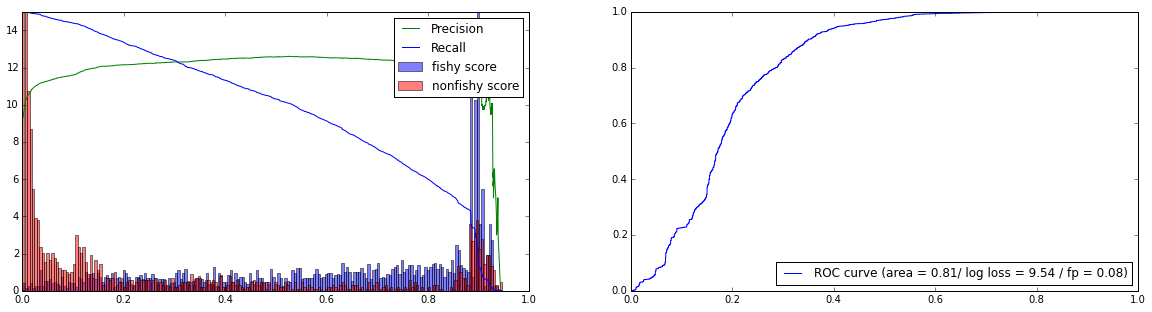

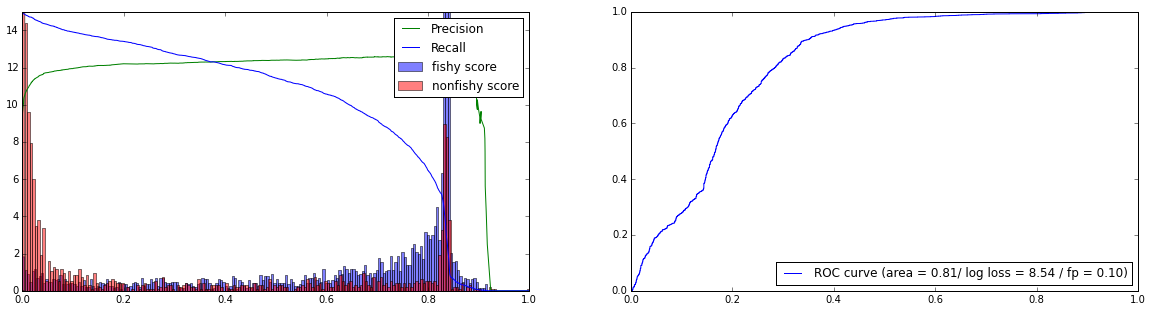

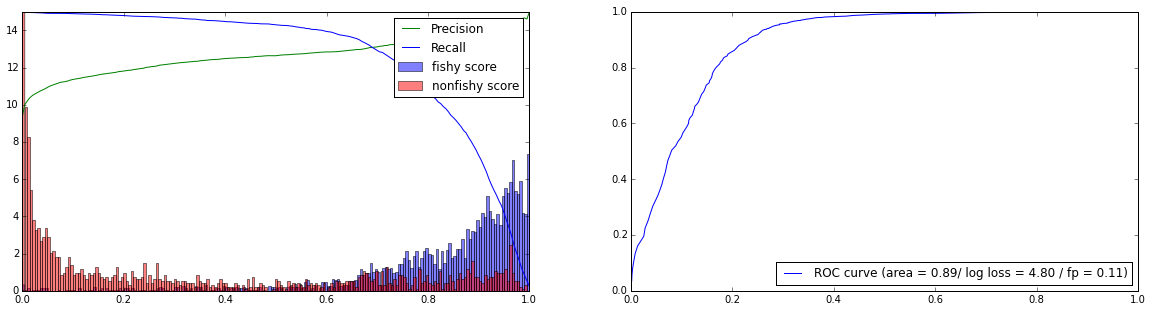

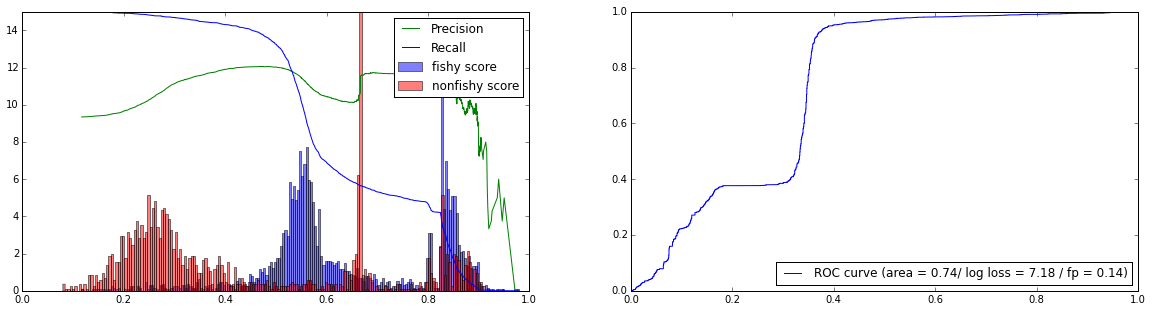

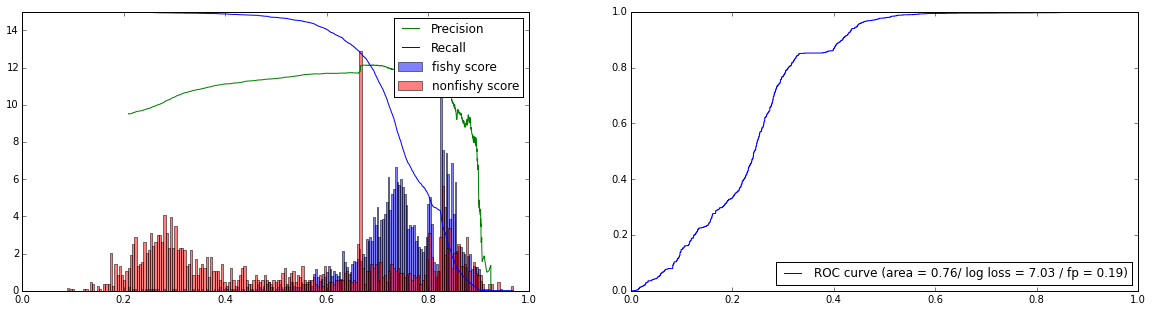

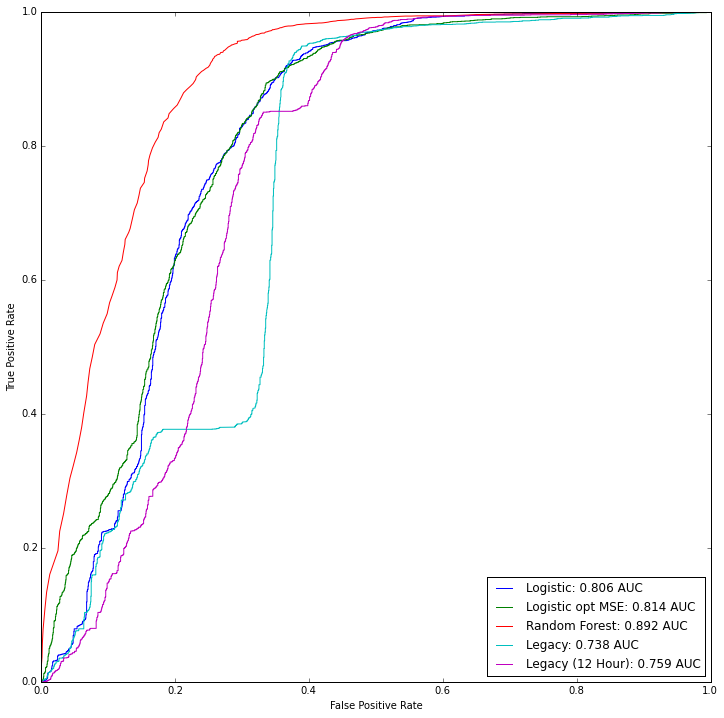

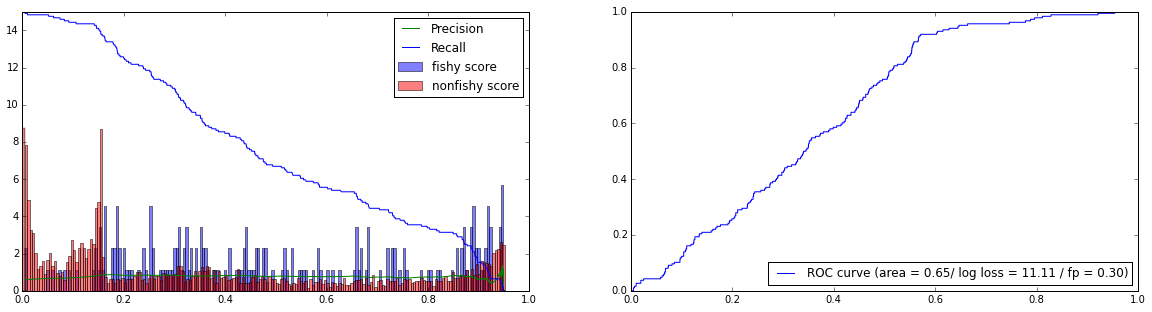

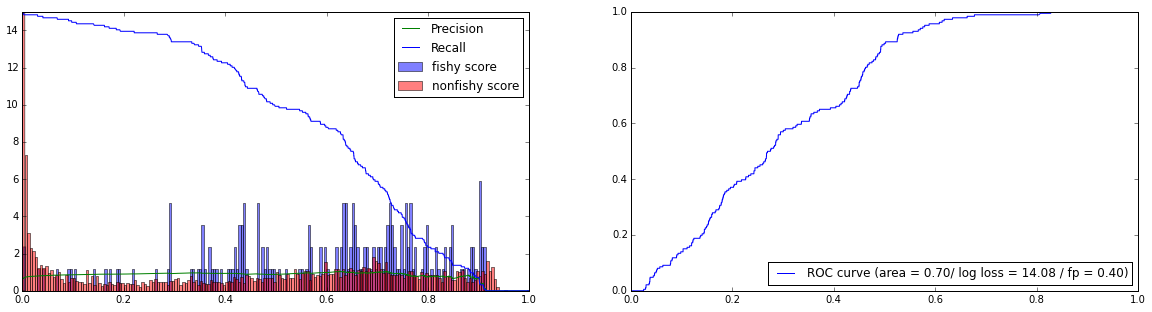

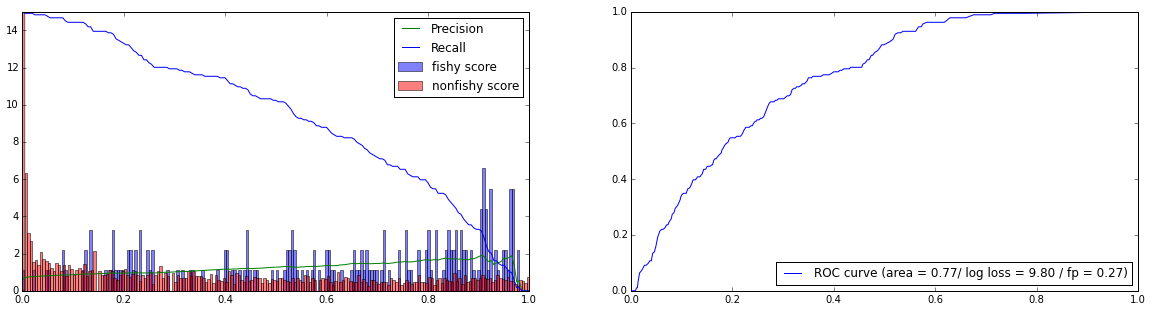

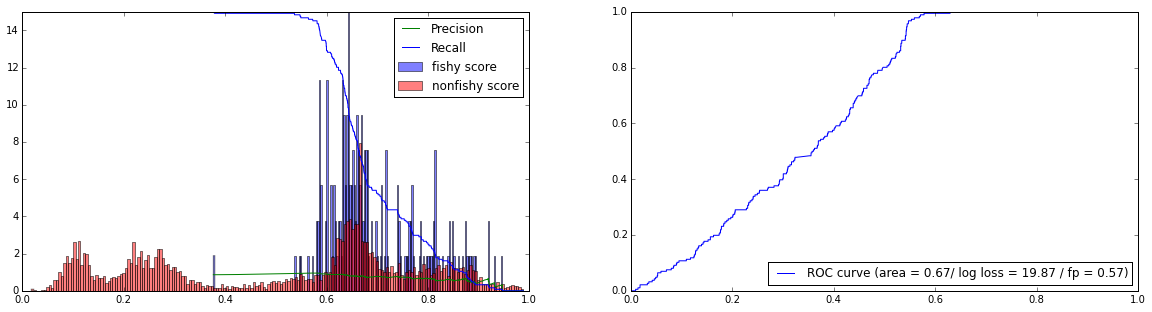

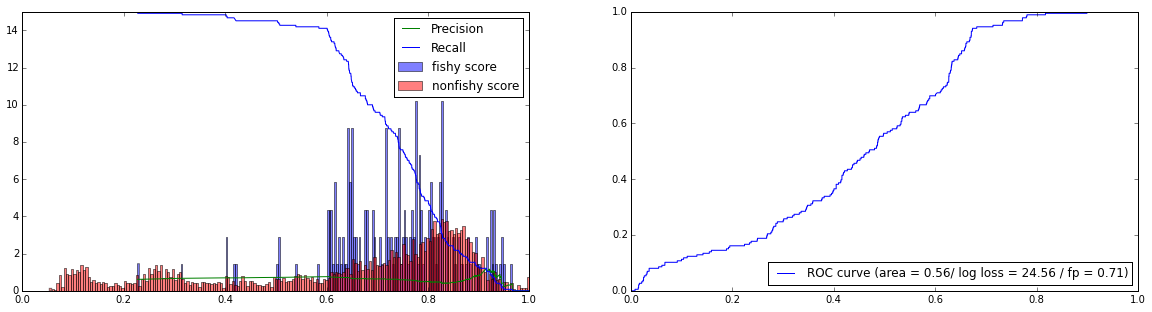

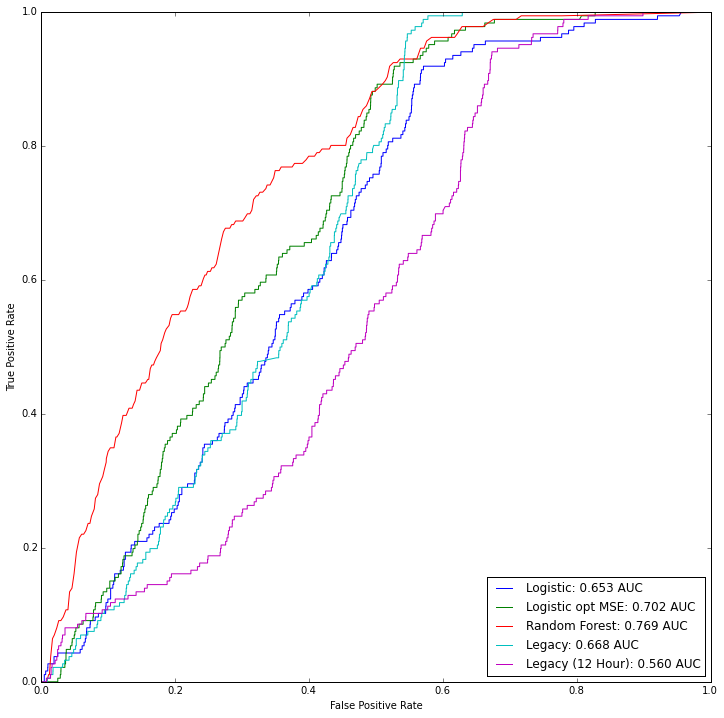

In [8]:
for vessel_class, xtest_class in  [("longliner", xtest_lline), 
                                   ("trawler", xtest_trawl), 
                                   ("purse seine", xtest_pseine)]:
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    for name, mdl in trained_models:
        evaluate_model(mdl, xtest_class, name=name)
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    compare_auc(trained_models, xtest_class)

# How does this model do on the slow transit tracks?

In [9]:
for name, mdl in trained_models:
    p = mdl.predict_proba(xtest_tran)[:,1]
    print name, p.mean(), (p > 0.5).mean()

Logistic 0.161457292668 0.0633023461709
Logistic opt MSE 0.158002750054 0.0637450199203
Random Forest 0.389183266932 0.378486055777
Legacy 0.623862134036 0.773351040283
Legacy (12 Hour) 0.66843170167 0.912793271359


## Results when not training with transit data.

    Logistic 0.838618506196 0.984949092519
    Logistic opt MSE 0.826260344662 0.986277113767
    Random Forest 0.718120849934 0.885790172643
    Legacy 0.623862134036 0.773351040283
    Legacy (12 Hour) 0.66843170167 0.912793271359
    
**If we don't train on these slow transit tracks, results are pretty awful**

# Dumping the model and using LogisticScorer

LogisticScorer is a simple reimplementation of the prediciton part of 
the logistic predictor. This way we can dump out the parameters from 
the model and then use it in the pipeline where we potentially can
optimize it for that particular application.

12.1068029515 -16.4217354415 81.0 21.3198531555 [ 3.68692544]
0.99999447821
12.1068029515 -16.4217354415 81.0 21.3198531555 [ 3.68692544]
0.99999447821
0.99999447821
12.1068029515 -16.4217354415 81.0 21.3198531555 [ 3.68692544]


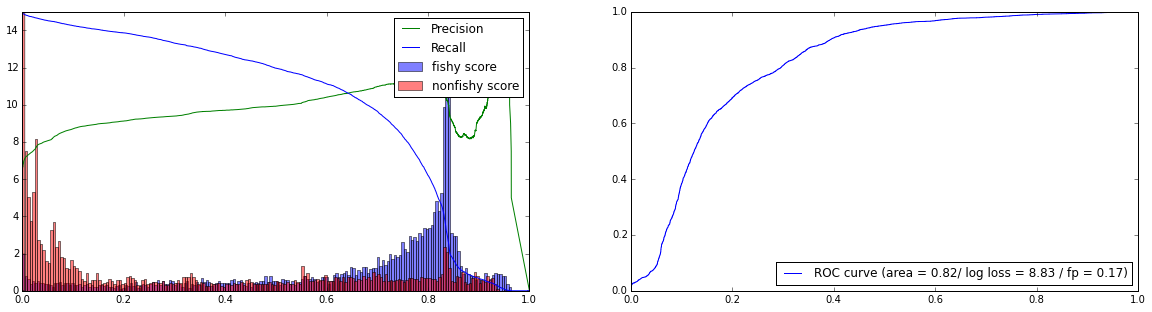

In [10]:
from logistic_model import LogisticScorer

scorer = LogisticScorer(**trained_models[1][1].dump_dict())

print scorer.fishing_score(xtest).max()
print scorer.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(scorer, xtest)